In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,roc_curve, auc,RocCurveDisplay, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier, LinearRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.feature_selection import chi2
import shap


In [ ]:
# Load the dataset as a pandas dataframe
from google.colab import files
upload  = files.upload()
df = pd.read_excel("thyroid_cancer_risk_data.xlsx")

Saving thyroid_cancer_risk_data.xlsx to thyroid_cancer_risk_data.xlsx


In [ ]:
# commands to just view the data

print(df.nunique())
print("\n",df.isnull().values.any())

Patient_ID             212691
Age                        75
Gender                      2
Country                    10
Ethnicity                   5
Family_History              2
Radiation_Exposure          2
Iodine_Deficiency           2
Smoking                     2
Obesity                     2
Diabetes                    2
TSH_Level                 991
T3_Level                  301
T4_Level                  751
Nodule_Size               501
Thyroid_Cancer_Risk         3
Diagnosis                   2
dtype: int64

 False


## **Exploratory Data Anaalysis**

In [ ]:
# Calculate Chi2 stats and p-values


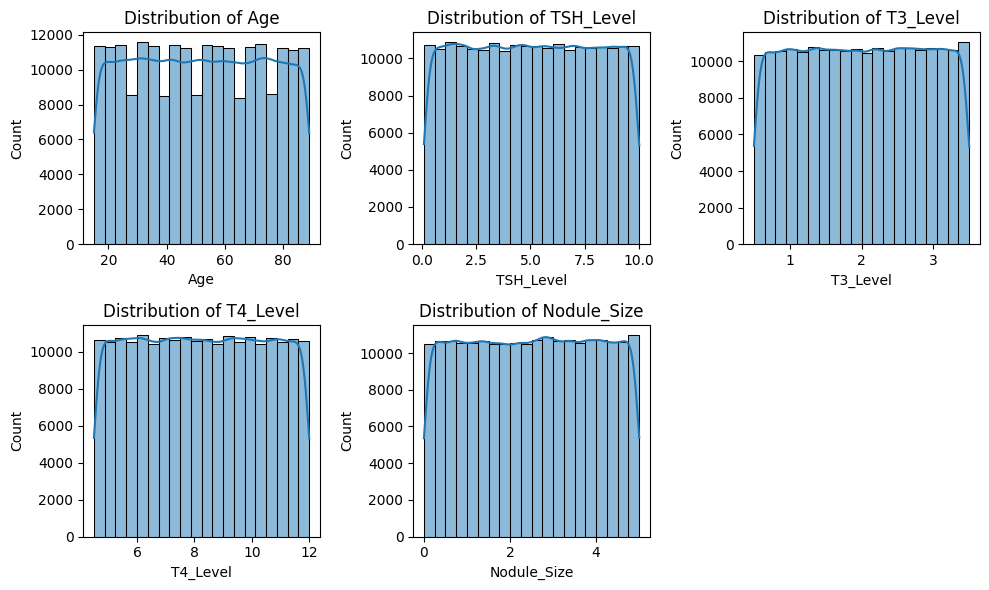

In [ ]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size'], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## **Pre-processing**


In [ ]:
non_num_feat_for_one_hot = ['Gender', 'Ethnicity', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'Thyroid_Cancer_Risk']
result_feature = ['Diagnosis']
drop_cols = ['Patient_ID', 'Country']

In [ ]:
# One-hot encoding all non numerical features except Diagnosis
df_encoded = pd.get_dummies(df, columns=non_num_feat_for_one_hot, dtype=int)

In [ ]:
# Check for any null values
print("Null values: ",df_encoded.isnull().values.any())
print(df_encoded.columns)

Null values:  False
Index(['Patient_ID', 'Age', 'Country', 'TSH_Level', 'T3_Level', 'T4_Level',
       'Nodule_Size', 'Diagnosis', 'Gender_Female', 'Gender_Male',
       'Ethnicity_African', 'Ethnicity_Asian', 'Ethnicity_Caucasian',
       'Ethnicity_Hispanic', 'Ethnicity_Middle Eastern', 'Family_History_No',
       'Family_History_Yes', 'Radiation_Exposure_No', 'Radiation_Exposure_Yes',
       'Iodine_Deficiency_No', 'Iodine_Deficiency_Yes', 'Smoking_No',
       'Smoking_Yes', 'Obesity_No', 'Obesity_Yes', 'Diabetes_No',
       'Diabetes_Yes', 'Thyroid_Cancer_Risk_High', 'Thyroid_Cancer_Risk_Low',
       'Thyroid_Cancer_Risk_Medium'],
      dtype='object')


In [ ]:
#Removing unneccessary cols
df2 = df_encoded.drop(drop_cols, axis=1)
print(df2.columns)

Index(['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size', 'Diagnosis',
       'Gender_Female', 'Gender_Male', 'Ethnicity_African', 'Ethnicity_Asian',
       'Ethnicity_Caucasian', 'Ethnicity_Hispanic', 'Ethnicity_Middle Eastern',
       'Family_History_No', 'Family_History_Yes', 'Radiation_Exposure_No',
       'Radiation_Exposure_Yes', 'Iodine_Deficiency_No',
       'Iodine_Deficiency_Yes', 'Smoking_No', 'Smoking_Yes', 'Obesity_No',
       'Obesity_Yes', 'Diabetes_No', 'Diabetes_Yes',
       'Thyroid_Cancer_Risk_High', 'Thyroid_Cancer_Risk_Low',
       'Thyroid_Cancer_Risk_Medium'],
      dtype='object')


In [ ]:
# Changing diagnosis to numerical
print(df2.head())
df2['Diagnosis'] = pd.factorize(df2['Diagnosis'])[0]
print(df2.head())

   Age  TSH_Level  T3_Level  T4_Level  Nodule_Size Diagnosis  Gender_Female  \
0   66       9.37      1.67      6.16         1.08    Benign              0   
1   29       1.83      1.73     10.54         4.05    Benign              0   
2   86       6.26      2.59     10.57         4.61    Benign              0   
3   75       4.10      2.62     11.04         2.46    Benign              1   
4   35       9.10      2.11     10.71         2.11    Benign              1   

   Gender_Male  Ethnicity_African  Ethnicity_Asian  ...  \
0            1                  0                0  ...   
1            1                  0                0  ...   
2            1                  0                0  ...   
3            0                  0                1  ...   
4            0                  1                0  ...   

   Iodine_Deficiency_Yes  Smoking_No  Smoking_Yes  Obesity_No  Obesity_Yes  \
0                      0           1            0           1            0   
1             

In [ ]:
# Identifying input features and output

X = df2.drop('Diagnosis', axis=1)   # Features
y = df2['Diagnosis']                # Target variable

In [ ]:
# Splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# standard scaling (only the numerical cols that have not been encoded)
cols_to_scale = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

sc = StandardScaler()

X_train[cols_to_scale] = sc.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = sc.transform(X_test[cols_to_scale])
X_val[cols_to_scale] = sc.transform(X_val[cols_to_scale])

In [ ]:
print(X_train.head())

             Age  TSH_Level  T3_Level  T4_Level  Nodule_Size  Gender_Female  \
119757 -1.012825  -0.165170  1.291836 -0.186086     0.889318              1   
135063  0.603225   1.529655 -0.842178 -1.596044     0.051601              0   
193619 -1.289862   1.337853  1.211090 -0.195332     0.737006              1   
174287  0.880262  -0.036141  0.761216 -1.554439     1.533184              1   
196577 -0.828133   0.476492 -1.361263 -1.355658     0.252376              1   

        Gender_Male  Ethnicity_African  Ethnicity_Asian  Ethnicity_Caucasian  \
119757            0                  0                1                    0   
135063            1                  0                0                    0   
193619            0                  0                0                    1   
174287            0                  0                0                    1   
196577            0                  0                0                    1   

        ...  Iodine_Deficiency_Yes  Smoking_

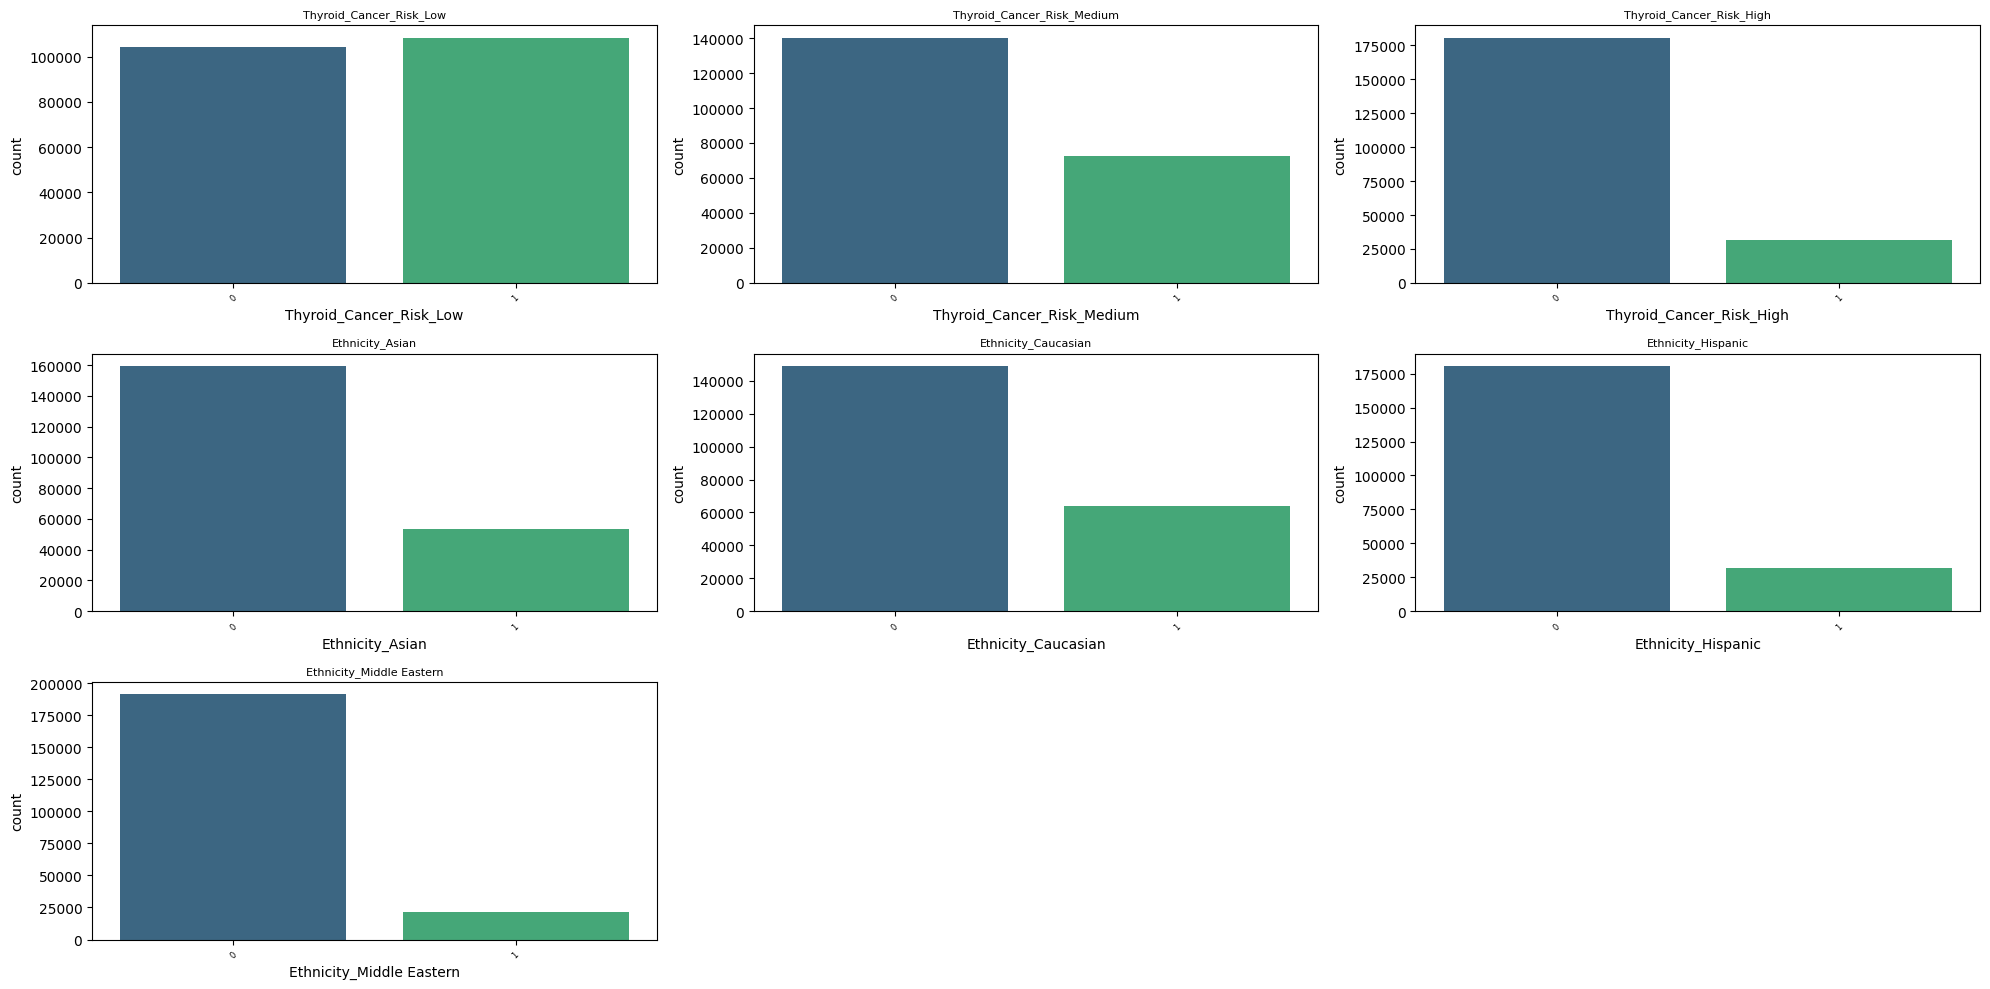

In [ ]:
encoded_cols = [
    'Thyroid_Cancer_Risk_Low', 'Thyroid_Cancer_Risk_Medium', 'Thyroid_Cancer_Risk_High','Ethnicity_Asian', 'Ethnicity_Caucasian', 'Ethnicity_Hispanic', 'Ethnicity_Middle Eastern'
]

plt.figure(figsize=(20, 10))

cols_per_row = 3
for i, col in enumerate(encoded_cols, 1):
    plt.subplot((len(encoded_cols) // cols_per_row + 1), cols_per_row, i)
    sns.countplot(data=df2, x=col, palette='viridis', hue=col, legend=False)
    plt.title(f'{col}', fontsize=8)
    plt.xticks(rotation=45, fontsize=6)

plt.tight_layout()
plt.show()

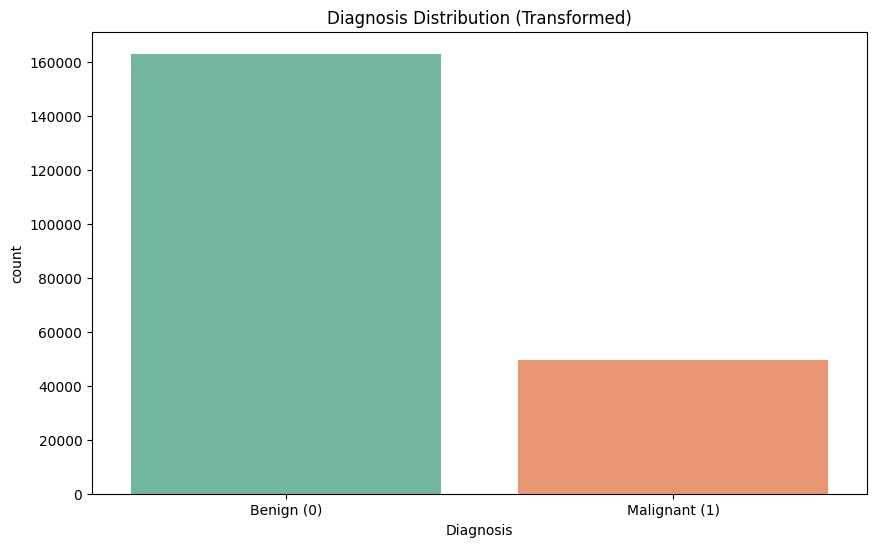

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Diagnosis', palette='Set2', hue='Diagnosis')
plt.title('Diagnosis Distribution (Transformed)')
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.show()

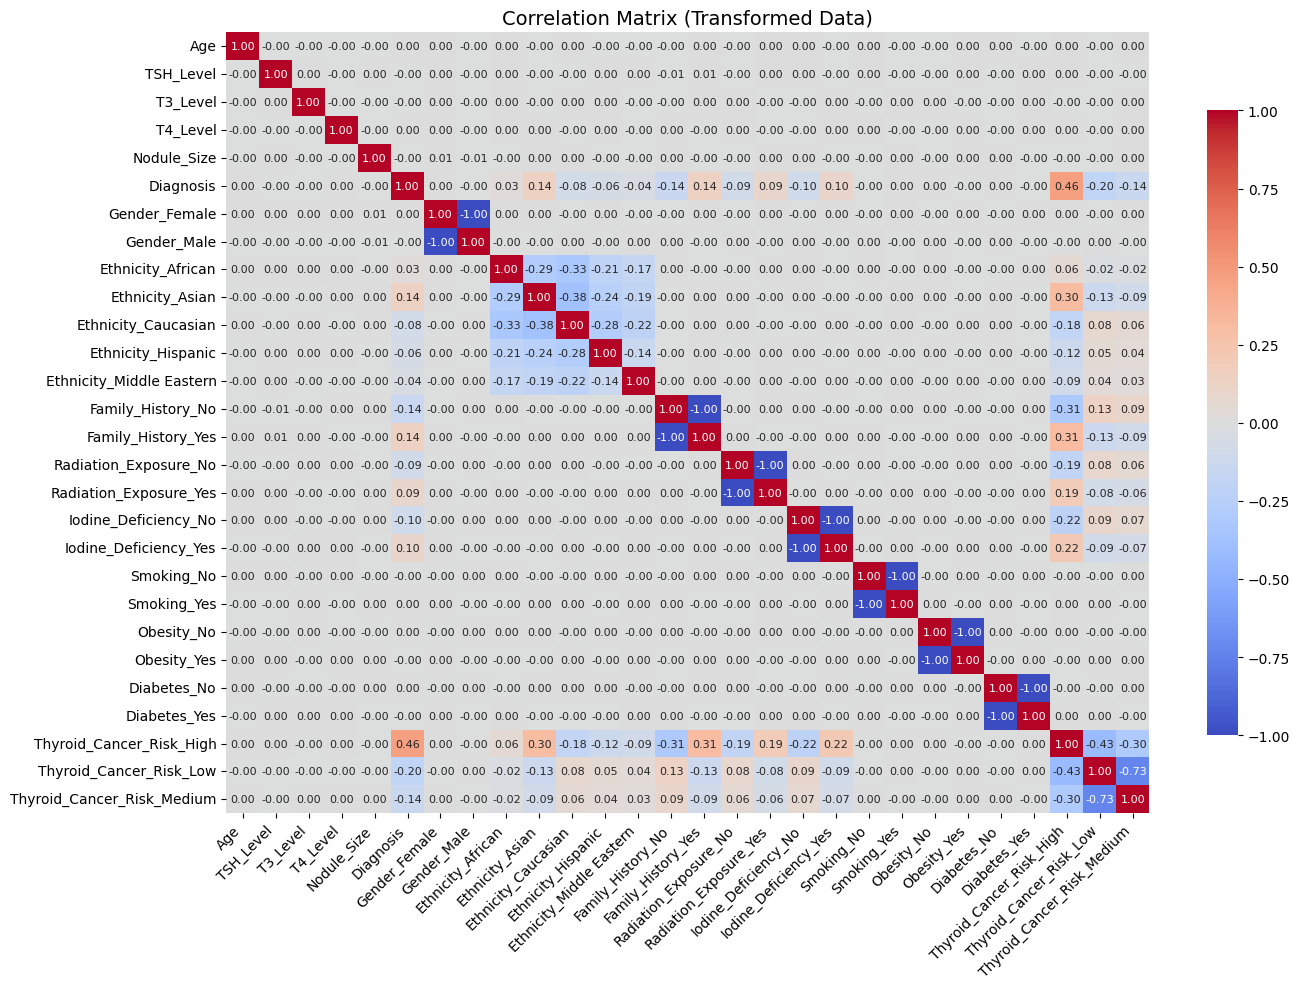

In [ ]:
corr_matrix = df2.corr()

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    annot_kws={"size": 8},
    cbar_kws={"shrink": 0.8}
)


plt.title('Correlation Matrix (Transformed Data)', fontsize=14)
plt.xticks(
    rotation=45,
    ha='right',
    fontsize=10
)
plt.yticks(
    rotation=0,
    fontsize=10
)

plt.tight_layout()

## **Class Imbalance:**

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)  # Training data

# Check class distribution for SMOTE
print("SMOTE class distribution for training data:\n", y_train_smote.value_counts())

# Random Oversampling
from imblearn.over_sampling import RandomOverSampler

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)  # Training data

# Check class distribution for Random Oversampling
print("Random Oversampling class distribution for training data:\n", y_train_ros.value_counts())

# ADASYN
from imblearn.over_sampling import ADASYN

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)  # Training data

# Check class distribution for ADASYN
print("ADASYN class distribution for training data:\n", y_train_adasyn.value_counts())

# Class imbalance for validation data
X_val_smote, y_val_smote = sm.fit_resample(X_val, y_val)  # Validation data
X_val_ros, y_val_ros = ros.fit_resample(X_val, y_val)  # Validation data
X_val_adasyn, y_val_adasyn = adasyn.fit_resample(X_val, y_val)  # Validation data

# Check class distribution for SMOTE, Random Oversampling, and ADASYN for validation data
print("SMOTE class distribution for validation data:\n", y_val_smote.value_counts())
print("Random Oversampling class distribution for validation data:\n", y_val_ros.value_counts())
print("ADASYN class distribution for validation data:\n", y_val_adasyn.value_counts())


SMOTE class distribution for training data:
 Diagnosis
0    85689
1    85689
Name: count, dtype: int64
Random Oversampling class distribution for training data:
 Diagnosis
0    85689
1    42844
Name: count, dtype: int64
ADASYN class distribution for training data:
 Diagnosis
1    88866
0    85689
Name: count, dtype: int64
SMOTE class distribution for validation data:
 Diagnosis
0    28548
1    28548
Name: count, dtype: int64
Random Oversampling class distribution for validation data:
 Diagnosis
0    28548
1    14274
Name: count, dtype: int64
ADASYN class distribution for validation data:
 Diagnosis
1    28696
0    28548
Name: count, dtype: int64


## **PCA**

In [ ]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val_smote)

explained_variance = pca.explained_variance_ratio_
print("Explained variance per component:", explained_variance)
print("Total explained variance:", explained_variance.sum())

Explained variance per component: [0.11086153 0.10971714 0.10935785 0.10903884 0.10760863 0.06417195
 0.05336929 0.04649131 0.04579234 0.03970579]
Total explained variance: 0.7961146635610051


## **KNN classification**

Trying for num of neighbours =  12
Acurracy: 0.8141371806238413
ROC AUC:  0.6586906893192369


Trying for num of neighbours =  13
Acurracy: 0.8173880336369254
ROC AUC:  0.6713656469491424


Trying for num of neighbours =  14
Acurracy: 0.8158835066226056
ROC AUC:  0.6637222970777926


Trying for num of neighbours =  15
Acurracy: 0.8181671636979124
ROC AUC:  0.673198045399649


Trying for num of neighbours =  16
Acurracy: 0.8166895032374197
ROC AUC:  0.6662545187780372


Trying for num of neighbours =  17
Acurracy: 0.8189462937588995
ROC AUC:  0.674950172216278


Trying for num of neighbours =  18
Acurracy: 0.8171999677601354
ROC AUC:  0.6679519094277162


Trying for num of neighbours =  19
Acurracy: 0.8193224255124795
ROC AUC:  0.675998089619929


Trying for num of neighbours =  20
Acurracy: 0.8176835657290239
ROC AUC:  0.6699127364341908


Trying for num of neighbours =  21
Acurracy: 0.8197254238198867
ROC AUC:  0.6768628423006623


Trying for num of neighbours =  22
Acurracy: 0.818865

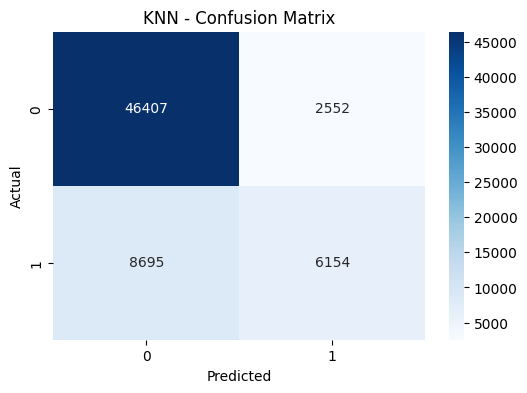

In [ ]:
knn_best = {'n': 0, 'acc': 0, 'knn': 0}

for n in range(12, 30):
  knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski', n_jobs=-1)
  knn.fit(X_train, y_train)
  result = knn.predict(X_val)

  knn_acc = accuracy_score(y_val, result)

  print("Trying for num of neighbours = ", n)
  print("Acurracy:", knn_acc)
  print("ROC AUC: ", roc_auc_score(y_val, result))

  if knn_acc > knn_best['acc']:
    knn_best['n'] = n
    knn_best['acc'] = knn_acc
    knn_best['knn'] = knn

  print("\n")

print("Best n:", knn_best['n'])
print("Best accuracy for validation:", knn_best['acc'])

y_pred = knn_best['knn'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report for test:\n", classification_report(y_test, y_pred))
print("ROC AUC for test: ", roc_auc_score(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## **Perceptron**




Trying for eta =  1
Acurracy: 0.8011606351253324
ROC AUC:  0.6667672091599373


Trying for eta =  0.1
Acurracy: 0.8011606351253324
ROC AUC:  0.6667672091599373


Trying for eta =  0.01
Acurracy: 0.6262325031568201
ROC AUC:  0.6065533301471856


Trying for eta =  0.001
Acurracy: 0.6262325031568201
ROC AUC:  0.6065533301471856


Trying for eta =  0.0001
Acurracy: 0.6262325031568201
ROC AUC:  0.6065533301471856


Best eta for validation: 1
Best accuracy for validation: 0.8011606351253324
Accuracy for test: 0.8086760280842528
Classification Report for test:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     48959
           1       0.63      0.43      0.51     14849

    accuracy                           0.81     63808
   macro avg       0.74      0.68      0.70     63808
weighted avg       0.79      0.81      0.79     63808

ROC AUC for test:  0.6758466405590318


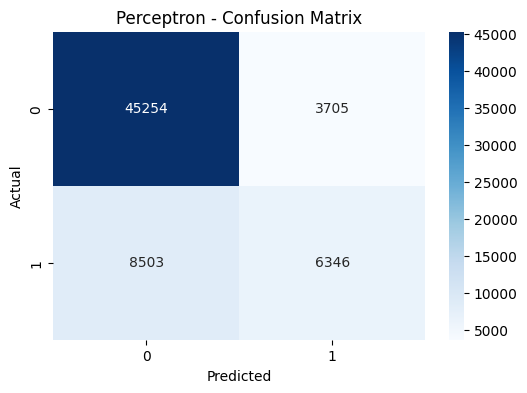

In [ ]:
ppn_best = {'eta': 0, 'acc': 0, 'ppn': 0}

for e in [1, 0.1, 0.01, 0.001, 0.0001]:
  ppn = Perceptron(max_iter=10000, eta0=e, random_state=10)
  ppn.fit(X_train, y_train)
  result = ppn.predict(X_val)

  ppn_acc = accuracy_score(y_val, result)

  print("Trying for eta = ", e)
  print("Acurracy:", ppn_acc)
  print("ROC AUC: ", roc_auc_score(y_val, result))

  if ppn_acc > ppn_best['acc']:
    ppn_best['eta'] = e
    ppn_best['acc'] = ppn_acc
    ppn_best['ppn'] = ppn

  print("\n")

print("Best eta for validation:", ppn_best['eta'])
print("Best accuracy for validation:", ppn_best['acc'])

y_pred = ppn_best['ppn'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report for test:\n", classification_report(y_test, y_pred))
print("ROC AUC for test: ", roc_auc_score(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Perceptron - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **Linear SVC**

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== Best Model by Accuracy ===
C: 0.1
Penalty: l1
Accuracy: 0.8242121383090191
AUC-ROC: 0.69049910676553


Accuracy for test: 0.8289086008024072
Classification Report for test:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     48959
           1       0.71      0.45      0.55     14849

    accuracy                           0.83     63808
   macro avg       0.78      0.70      0.72     63808
weighted avg       0.82      0.83      0.81     63808



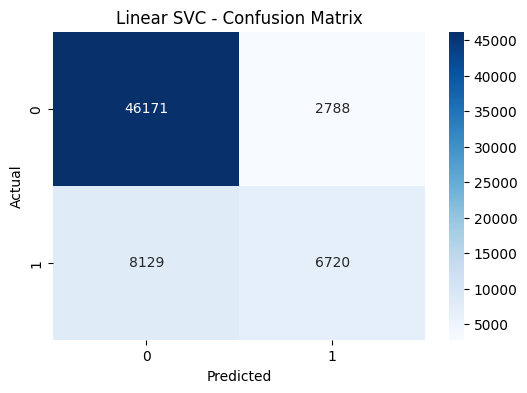


SHAP Values (Best Accuracy Model):
Thyroid_Cancer_Risk_Low       0.207264
Thyroid_Cancer_Risk_High      0.190294
Thyroid_Cancer_Risk_Medium    0.178297
Family_History_Yes            0.047855
Family_History_No             0.045605
Ethnicity_African             0.004750
Iodine_Deficiency_No          0.003407
TSH_Level                     0.002106
Ethnicity_Hispanic            0.001738
Diabetes_Yes                  0.001564
Obesity_No                    0.001287
Nodule_Size                   0.000986
Gender_Female                 0.000813
Radiation_Exposure_No         0.000744
Ethnicity_Middle Eastern      0.000678
Smoking_Yes                   0.000566
T4_Level                      0.000500
T3_Level                      0.000360
Ethnicity_Caucasian           0.000359
Ethnicity_Asian               0.000000
Gender_Male                   0.000000
Age                           0.000000
Radiation_Exposure_Yes        0.000000
Smoking_No                    0.000000
Iodine_Deficiency_Yes       

In [ ]:
# Hyperparameter grids
C_vals = [0.1, 1, 5, 10, 25]
penalties = ['l1', 'l2']

best_accuracy = 0
best_auc = 0
best_model_acc = None
best_metrics_acc = {}

for C in C_vals:
    for penalty in penalties:
        if penalty == 'l1':
            loss = 'squared_hinge'
            dual = False
        else:
            loss = 'hinge'
            dual = True

        model = LinearSVC(
            C=C,
            penalty=penalty,
            loss=loss,
            dual=dual,
            class_weight=None,
            random_state=42,
            max_iter=10000
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)

        auc_roc = None
        if len(y_val.unique()) == 2:
            decision_scores = model.decision_function(X_val)
            auc_roc = roc_auc_score(y_val, decision_scores)

        # Track best accuracy model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_metrics_acc = {
                'C': C,
                'penalty': penalty,
                'accuracy': accuracy,
                'confusion_matrix': cm,
                'auc_roc': auc_roc,
                'model': model
            }

# Print best model by Accuracy
print("\n=== Best Model by Accuracy ===")
print(f"C: {best_metrics_acc['C']}")
print(f"Penalty: {best_metrics_acc['penalty']}")
print(f"Accuracy: {best_metrics_acc['accuracy']}")
if best_metrics_acc['auc_roc'] is not None:
    print(f"AUC-ROC: {best_metrics_acc['auc_roc']}")

print("\n")

y_pred = best_metrics_acc['model'].predict(X_test)
print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report for test:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Linear SVC - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SHAP values for best accuracy model
explainer = shap.LinearExplainer(best_metrics_acc['model'], X_train)
shap_values = explainer.shap_values(X_test)
mean_abs_shap = pd.Series(np.abs(shap_values).mean(axis=0), index=X_train.columns).sort_values(ascending=False)
print("\nSHAP Values (Best Accuracy Model):")
print(mean_abs_shap)

## **SVC**


=== Best rbf kernel ===
C: 0.1, gamma: scale
Accuracy: 0.819667
AUC-ROC: 0.698419

Confusion Matrix:
[[2705  158]
 [ 507  380]]

Classification Report for test:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      2863
           1       0.71      0.43      0.53       887

    accuracy                           0.82      3750
   macro avg       0.77      0.69      0.71      3750
weighted avg       0.81      0.82      0.81      3750



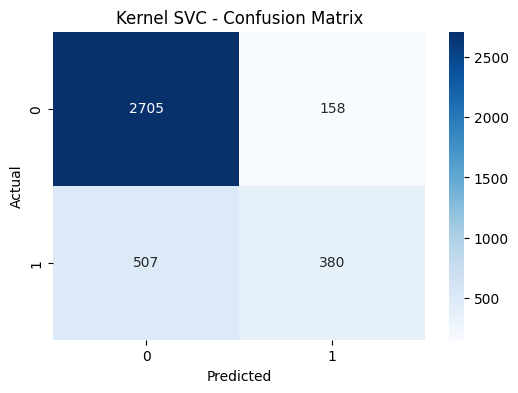


=== Best sigmoid kernel ===
C: 0.1, gamma: auto
Accuracy: 0.819667
AUC-ROC: 0.677451

Confusion Matrix:
[[2705  158]
 [ 507  380]]

Classification Report for test:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      2863
           1       0.71      0.43      0.53       887

    accuracy                           0.82      3750
   macro avg       0.77      0.69      0.71      3750
weighted avg       0.81      0.82      0.81      3750



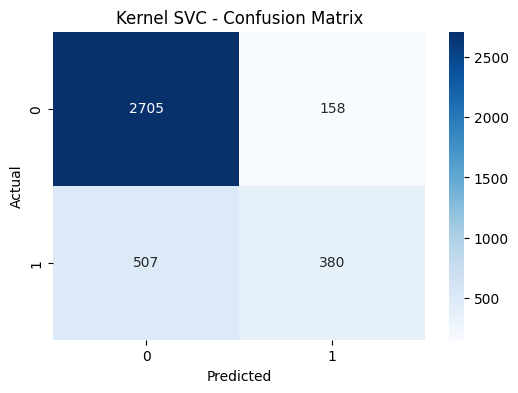


=== Best poly kernel ===
C: 0.1, gamma: scale
Accuracy: 0.819667
AUC-ROC: 0.679766

Confusion Matrix:
[[2705  158]
 [ 507  380]]

Classification Report for test:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      2863
           1       0.71      0.43      0.53       887

    accuracy                           0.82      3750
   macro avg       0.77      0.69      0.71      3750
weighted avg       0.81      0.82      0.81      3750



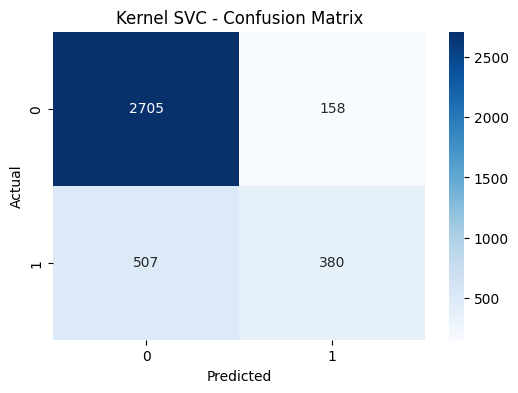

In [ ]:
# Hyperparameter grids
kernels = ['rbf', 'sigmoid', 'poly']
C_vals = [0.1, 1, 5]
gammas = ['scale', 'auto', 0.1]

## Using a downsized dataset

svc_df = df2.sample(n=18750, random_state=42)

X_svc = svc_df.drop('Diagnosis', axis=1)
y_svc = svc_df['Diagnosis']

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size=0.2, random_state=1, stratify=y_svc)
X_train_svc, X_val_svc, y_train_svc, y_val_svc = train_test_split(X_train_svc, y_train_svc, test_size=0.2, random_state=42)

cols_to_scale = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

sc_svc = StandardScaler()

X_train_svc[cols_to_scale] = sc_svc.fit_transform(X_train_svc[cols_to_scale])
X_test_svc[cols_to_scale] = sc_svc.transform(X_test_svc[cols_to_scale])
X_val_svc[cols_to_scale] = sc_svc.transform(X_val_svc[cols_to_scale])
##

best_models = {
    'sigmoid': {'model': None, 'accuracy': 0, 'C': None, 'gamma': None},
    'rbf': {'model': None, 'accuracy': 0, 'C': None, 'gamma': None},
    'poly': {'model': None, 'accuracy': 0, 'C': None, 'gamma': None}
}

for kernel in kernels:
    for C in C_vals:
        for gamma in gammas:
            # Skip invalid combinations
            if kernel == 'linear' and gamma != 'scale':
                continue

            model = SVC(
                kernel=kernel,
                C=C,
                gamma=gamma,
                probability=True,  # Required for AUC-ROC
                random_state=42
            )

            model.fit(X_train_svc, y_train_svc)
            y_pred = model.predict(X_val_svc)
            accuracy = accuracy_score(y_val_svc, y_pred)

            # Update best model if current is better
            if accuracy > best_models[kernel]['accuracy']:
                best_models[kernel]['model'] = model
                best_models[kernel]['accuracy'] = accuracy
                best_models[kernel]['C'] = C
                best_models[kernel]['gamma'] = gamma

# Print results for each kernel
for kernel in kernels:
    best = best_models[kernel]
    model = best['model']

    # Get predictions and probabilities
    y_pred = model.predict(X_test_svc)
    y_proba = model.predict_proba(X_test_svc)[:, 1]  # Probability of positive class

    # Calculate metrics
    cm = confusion_matrix(y_test_svc, y_pred)
    auc_roc = roc_auc_score(y_test_svc, y_proba)

    print(f"\n=== Best {kernel} kernel ===")
    print(f"C: {best['C']}, gamma: {best['gamma']}")
    print(f"Accuracy: {best['accuracy']:.6f}")
    print(f"AUC-ROC: {auc_roc:.6f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report for test:\n", classification_report(y_test_svc, y_pred))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Kernel SVC - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## **Random Forest**

In [ ]:
# Your training and testing data
# X_train, X_test, y_train, y_test should already be defined

# Hyperparameter lists
n_estimators_list = [100, 200]
max_depth_list = [5, 10, 20]
min_samples_split_list = [2, 5, 10]

# Track best model
best_accuracy = 0
best_params = {}
best_model = None

# Train all combinations
for n_est in n_estimators_list:
    for depth in max_depth_list:
        for min_split in min_samples_split_list:
            model = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                min_samples_split=min_split,
                class_weight=None,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'n_estimators': n_est,
                    'max_depth': depth,
                    'min_samples_split': min_split
                }
                best_model = model

# Results
print("=== BEST RANDOM FOREST MODEL ===")
print(", ".join([f"{key}: {value}" for key, value in best_params.items()]))
print(f"Accuracy: {best_accuracy}")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_model.predict(X_test)))
print("Classification Report for test:\n", classification_report(y_test, y_pred))

## Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# If shap_values is a list, it's per class — usually for binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_to_use = shap_values[1]  # Class 1 shap values
else:
    shap_values_to_use = shap_values

# Make sure shap_values_to_use is a numpy array
shap_values_to_use = np.array(shap_values_to_use)

# Now it should have shape (num_samples, num_features)
if shap_values_to_use.ndim == 3:
    # Collapse first dimension if needed
    shap_values_to_use = shap_values_to_use[:, :, 1]  # class 1

shap_df = pd.DataFrame(shap_values_to_use, columns=X_test.columns)
mean_shap = shap_df.abs().mean().sort_values(ascending=False)
print("\nSHAP Values (Best RF Model):")
print(mean_shap)

=== BEST RANDOM FOREST MODEL ===
n_estimators: 100, max_depth: 5, min_samples_split: 2
Accuracy: 0.8289086008024072
AUC-ROC: 0.7006708542485569

Confusion Matrix:
[[46171  2788]
 [ 8129  6720]]
Classification Report for test:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     48959
           1       0.71      0.45      0.55     14849

    accuracy                           0.83     63808
   macro avg       0.78      0.70      0.72     63808
weighted avg       0.82      0.83      0.81     63808


SHAP Values (Best RF Model):
Thyroid_Cancer_Risk_High      0.076215
Thyroid_Cancer_Risk_Low       0.029332
Thyroid_Cancer_Risk_Medium    0.020699
Ethnicity_Asian               0.012867
Family_History_Yes            0.010920
Family_History_No             0.007396
Iodine_Deficiency_No          0.004800
Iodine_Deficiency_Yes         0.003796
Radiation_Exposure_No         0.003562
Radiation_Exposure_Yes        0.003509
Ethnicity_Caucasian       

## **Logistic Regresssion**

In [ ]:
# Set up the parameter grid
param_grid_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cg'],
    'penalty': ['l2'],
    'max_iter': [500, 1000, 2000]


}


# Instantiate GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced'),
                       param_grid=param_grid_lr,
                       cv=5,
                       scoring='f1_macro',
                       n_jobs=-1)

# Fit the model
grid_lr.fit(X_train, y_train)

# Evaluate
print("Best Parameters:", grid_lr.best_params_)

best_lr = grid_lr.best_estimator_
y_pred = best_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8289086008024072
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     48959
           1       0.71      0.45      0.55     14849

    accuracy                           0.83     63808
   macro avg       0.78      0.70      0.72     63808
weighted avg       0.82      0.83      0.81     63808



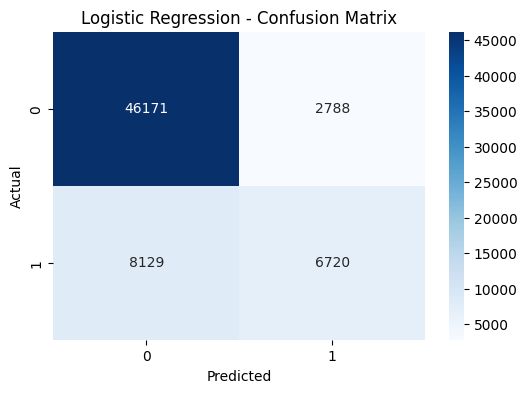

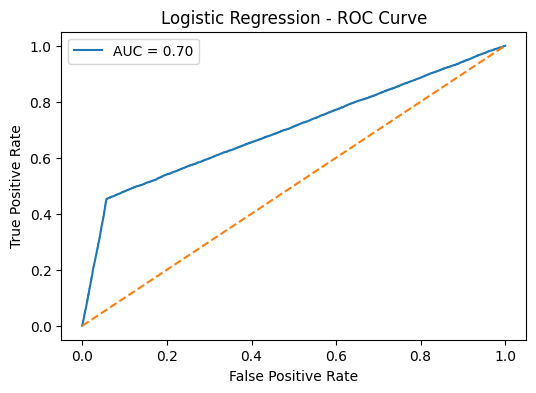

In [ ]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
y_probs = best_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## **Decision Tree**

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.7885061434302909
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87     48959
           1       0.55      0.47      0.51     14849

    accuracy                           0.79     63808
   macro avg       0.70      0.68      0.69     63808
weighted avg       0.78      0.79      0.78     63808



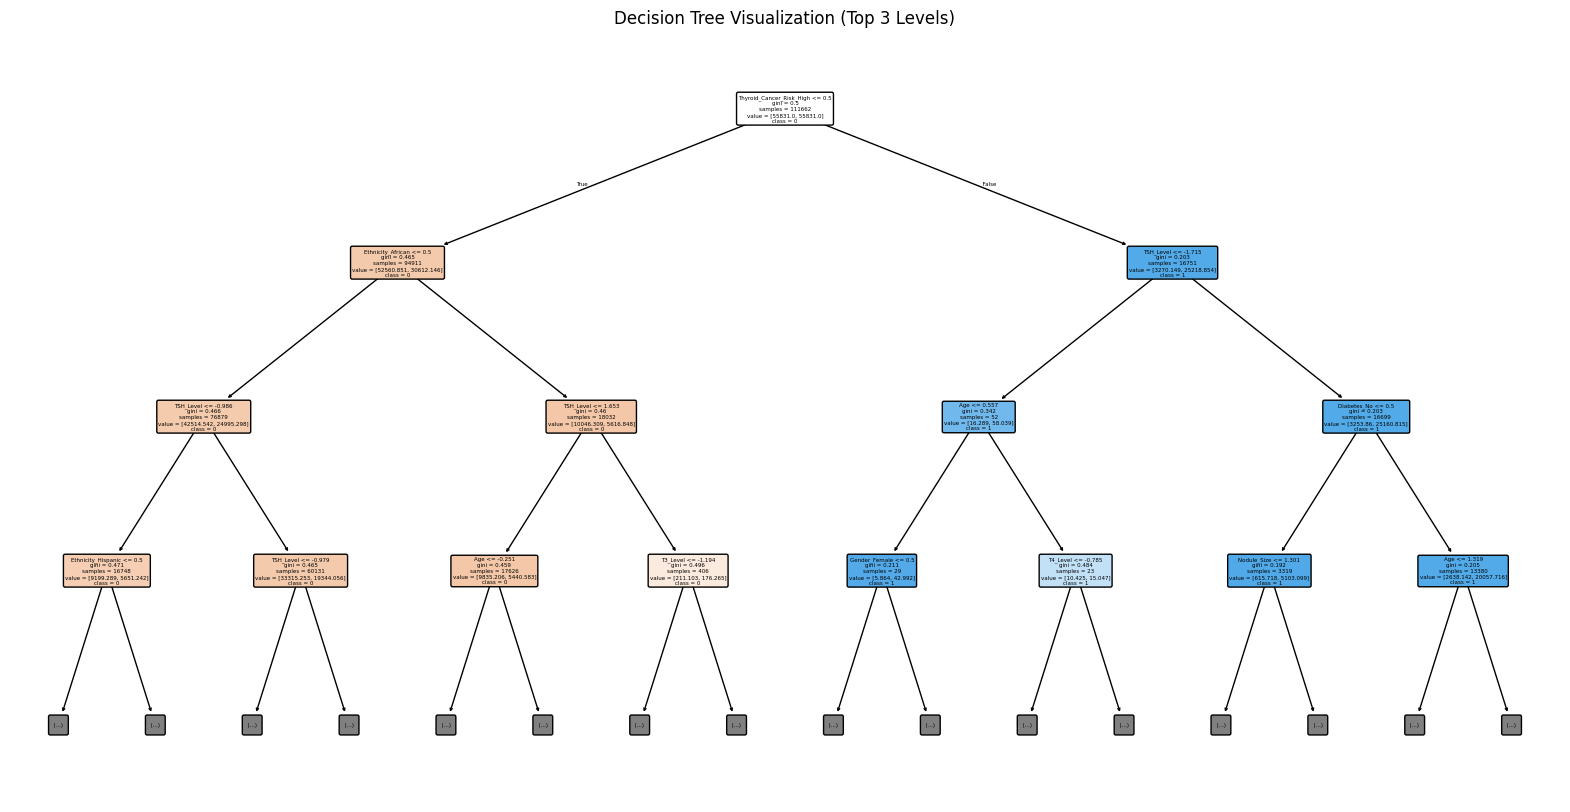

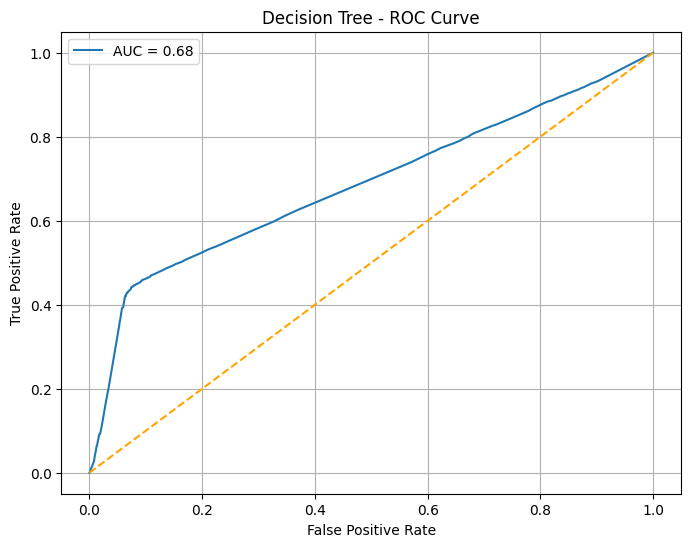

In [ ]:
from sklearn.tree import DecisionTreeClassifier  # Make sure to import
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree # Import plot_tree for visualization
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for array operations
import seaborn as sns
from sklearn.metrics import confusion_matrix

param_grid_dt = {
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                       param_grid=param_grid_dt,
                       cv=5, scoring='f1_macro')

grid_dt.fit(X_train, y_train)

print("Best Parameters:", grid_dt.best_params_)

# Predict using best estimator
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# --- Visualization of the Decision Tree ---
plt.figure(figsize=(20, 10))  # Wider figure for bigger trees
plot_tree(best_dt,
          feature_names=X_train.columns,
          class_names=[str(cls) for cls in np.unique(y_train)],
          filled=True,
          rounded=True,
          max_depth=3)  #  show top 3 levels
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]  # Probabilities for class 1

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'AUC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Adaline**

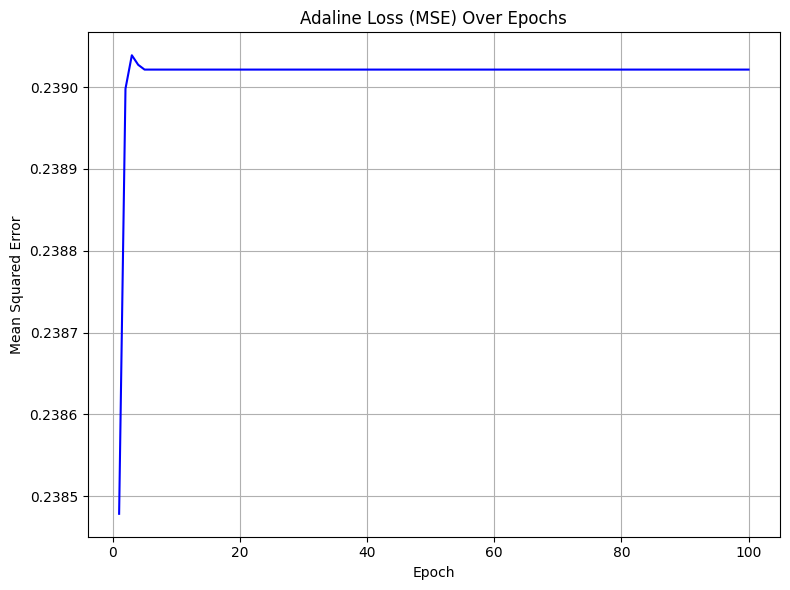

Accuracy: 0.7784760531594784
Confusion Matrix:
 [[42172  6787]
 [ 7348  7501]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86     48959
           1       0.52      0.51      0.51     14849

    accuracy                           0.78     63808
   macro avg       0.69      0.68      0.69     63808
weighted avg       0.78      0.78      0.78     63808



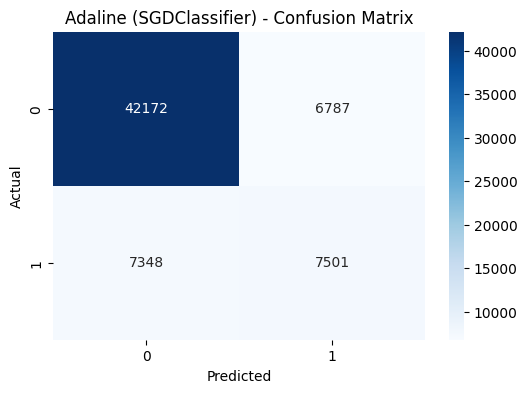

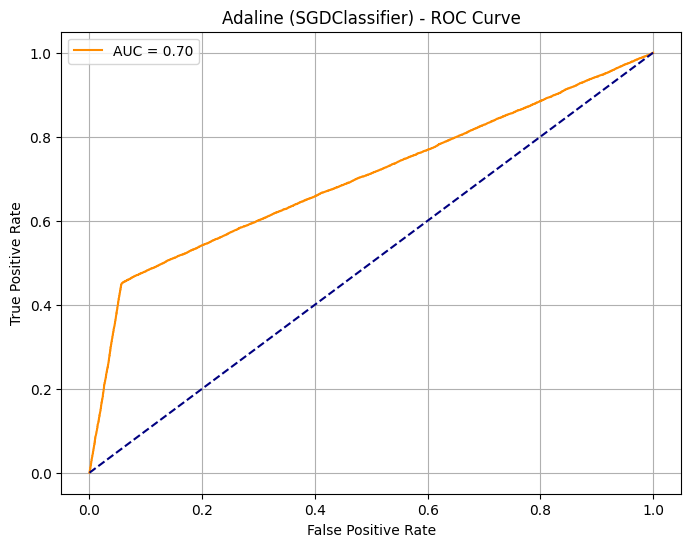

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

# Use all features for better model performance
X_train_vis = X_train_smote
X_test_vis = X_test

# Initialize the classifier
adaline = SGDClassifier(loss='squared_error', learning_rate='constant', eta0=0.01,
                        max_iter=1, random_state=42, tol=None, warm_start=True)

# Partial fit setup
n_epochs = 100
loss_values = []

classes = np.unique(y_train_smote)
adaline.partial_fit(X_train_vis, y_train_smote, classes=classes)

# Track MSE loss over epochs using partial_fit
for epoch in range(n_epochs):
    y_train_pred = adaline.predict(X_train_vis)
    loss = mean_squared_error(y_train_smote, y_train_pred)
    loss_values.append(loss)
    adaline.partial_fit(X_train_vis, y_train_smote)

# Plot loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_epochs + 1), loss_values, color='blue')
plt.title("Adaline Loss (MSE) Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Final evaluation
y_pred_adaline = adaline.predict(X_test_vis)
print("Accuracy:", accuracy_score(y_test, y_pred_adaline))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adaline))
print("Classification Report:\n", classification_report(y_test, y_pred_adaline))


# --- Confusion Matrix Plot ---
conf_matrix = confusion_matrix(y_test, y_pred_adaline)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Adaline (SGDClassifier) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#ROC-AUC
y_scores = adaline.decision_function(X_test_vis)  # raw scores

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaline (SGDClassifier) - ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Linear Regression**

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)


def predict_from_model(data, trained_model):
    """
    data: 2D array or DataFrame of features (same structure as training data)
    trained_model: a fitted sklearn model
    Returns: model predictions
    """
    return trained_model.predict(data)

print(predict_from_model(X_test, model))
y_pred = predict_from_model(X_test, model)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² score:", r2_score(y_test, y_pred))

[0.15340115 0.14275658 0.70003661 ... 0.70481763 0.70167884 0.15391791]
Mean Squared Error: 0.13922655189427557
R² score: 0.2202729764022896


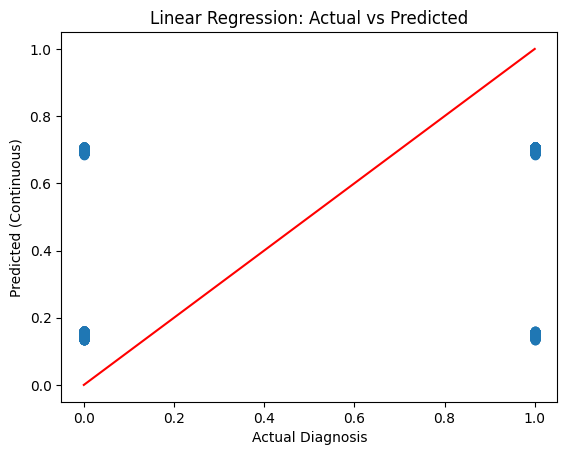

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Diagnosis")
plt.ylabel("Predicted (Continuous)")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # perfect fit line
plt.show()

## **Naive Bayes**

In [ ]:
# Train the model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict class labels and class probabilities
y_pred = nb_model.predict(X_test)
y_score = nb_model.predict_proba(X_test)[:, 1]  # use probability for class 1

# Compute AUC (binary)
auc = roc_auc_score(y_test, y_score)

# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("AUC:", auc)

# We could use MultinomialNB, or BernoulliNB if features are mostly 0/1 (like post-one-hot-encoding)

Accuracy: 0.8171389167502507
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     48959
           1       0.65      0.46      0.54     14849

    accuracy                           0.82     63808
   macro avg       0.75      0.69      0.71     63808
weighted avg       0.80      0.82      0.81     63808

[[45242  3717]
 [ 7951  6898]]
AUC: 0.7001272177351352


## **Neural Networks using Keras**

2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5584/5584 - 16s - 3ms/step - accuracy: 0.8224 - loss: 0.4630 - val_accuracy: 0.8270 - val_loss: 0.4537
Epoch 2/50
5584/5584 - 14s - 2ms/step - accuracy: 0.8274 - loss: 0.4541 - val_accuracy: 0.8270 - val_loss: 0.4523
Epoch 3/50
5584/5584 - 14s - 3ms/step - accuracy: 0.8276 - loss: 0.4526 - val_accuracy: 0.8270 - val_loss: 0.4520
Epoch 4/50
5584/5584 - 21s - 4ms/step - accuracy: 0.8276 - loss: 0.4521 - val_accuracy: 0.8270 - val_loss: 0.4523
Epoch 5/50
5584/5584 - 14s - 3ms/step - accuracy: 0.8276 - loss: 0.4522 - val_accuracy: 0.8270 - val_loss: 0.4536
Epoch 6/50
5584/5584 - 14s - 3ms/step - accuracy: 0.8275 - loss: 0.4521 - val_accuracy: 0.8270 - val_loss: 0.4519
Epoch 7/50
5584/5584 - 20s - 4ms/step - accuracy: 0.8275 - loss: 0.4519 - val_accuracy: 0.8270 - val_loss: 0.4520
Epoch 8/50
5584/5584 - 14s - 2ms/step - accuracy: 0.8275 - loss: 0.4519 - val_accuracy: 0.8270 - val_loss: 0.4547
Epoch 9/50
5584/5584 - 14s - 3ms/step - accuracy: 0.8275 - loss: 0.4518 - val_accuracy: 

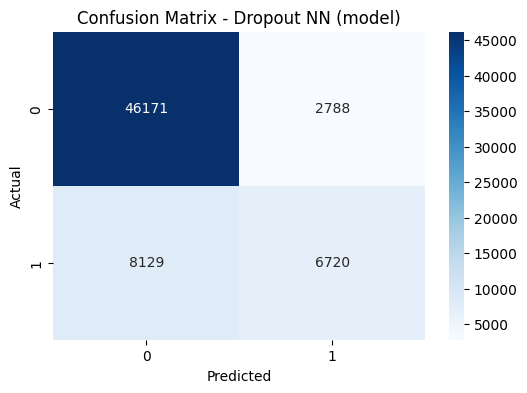

Accuracy (model): 0.8289086008024072
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     48959
           1       0.71      0.45      0.55     14849

    accuracy                           0.83     63808
   macro avg       0.78      0.70      0.72     63808
weighted avg       0.82      0.83      0.81     63808

AUC (model): 0.6966753732296969


In [ ]:
# One-hot encode your multi-class target
num_classes = len(np.unique(y_train))
print(num_classes)
y_train_cat = to_categorical(y_train, num_classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=16,  # Still using smaller batch for stability
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop]
)

# Evaluate
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_score = y_pred_prob[:, 1]
auc_score = roc_auc_score(y_test, y_score)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Dropout NN (model)")
plt.show()

# Print final metrics
print("Accuracy (model):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC (model):", auc_score)





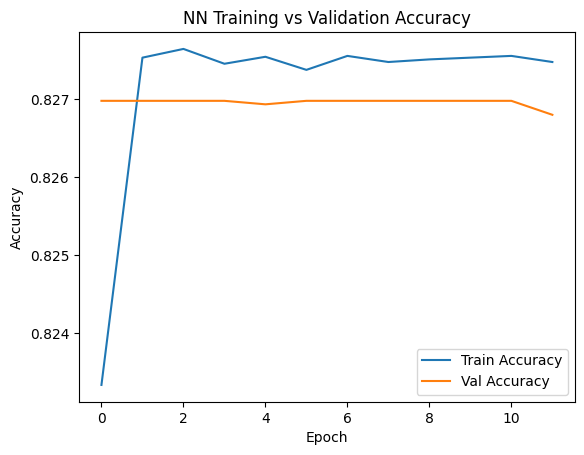

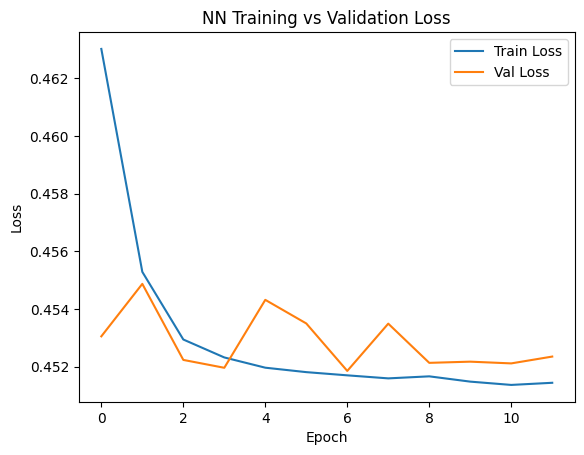

In [ ]:
#Accuracy and Loss Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('NN Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Training vs Validation Loss')
plt.legend()
plt.show()

#These graphs are labeled "Training vs Validation" because they come from Keras' internal training
#process. We used validation_split=0.2, which means these metrics are based on the training data and
#a held-out validation set — not the test set. The test set is only used at the end for final evaluation.

## **SHAP (for NN)**


In [ ]:
X_test_input = pd.DataFrame(X_test, columns=X.columns)

feature_names = []
for col in X_test_input.columns:
    if col in ['Thyroid_Cancer_Risk_High', 'Thyroid_Cancer_Risk_Low', 'Thyroid_Cancer_Risk_Medium']:
        feature_names.append('(Label) ' + col)  # Mark them obviously
    else:
        feature_names.append(col)

background = shap.utils.sample(X_test_input, 50, random_state=42)

def predict_proba_class1(x):
    preds = model.predict(x)
    return preds[:, 1]

explainer = shap.KernelExplainer(predict_proba_class1, background)

shap_values = explainer.shap_values(X_test_input[:10])

shap.summary_plot(shap_values, X_test_input[:10], feature_names=feature_names)
shap.summary_plot(shap_values, X_test_input[:10], feature_names=feature_names, plot_type="bar")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3285/3285 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2492/3285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



---


# **MODELS AFTER USING PCA AND DEALING WITH CLASS IMBALANCE**

---





## **KNN classification**

Trying for num of neighbours =  12
Acurracy: 0.6585750315258512
ROC AUC:  0.6585750315258512


Trying for num of neighbours =  13
Acurracy: 0.6521647751155948
ROC AUC:  0.6521647751155947


Trying for num of neighbours =  14
Acurracy: 0.6599236373826538
ROC AUC:  0.6599236373826537


Trying for num of neighbours =  15
Acurracy: 0.6538461538461539
ROC AUC:  0.6538461538461537


Trying for num of neighbours =  16
Acurracy: 0.6603089533417402
ROC AUC:  0.6603089533417403


Trying for num of neighbours =  17
Acurracy: 0.6539162112932605
ROC AUC:  0.6539162112932604


Trying for num of neighbours =  18
Acurracy: 0.6604315538741768
ROC AUC:  0.660431553874177


Trying for num of neighbours =  19
Acurracy: 0.6544766708701135
ROC AUC:  0.6544766708701135


Trying for num of neighbours =  20
Acurracy: 0.6600287235533138
ROC AUC:  0.6600287235533138


Trying for num of neighbours =  21
Acurracy: 0.6548795011909766
ROC AUC:  0.6548795011909767


Trying for num of neighbours =  22
Acurracy: 0.6593

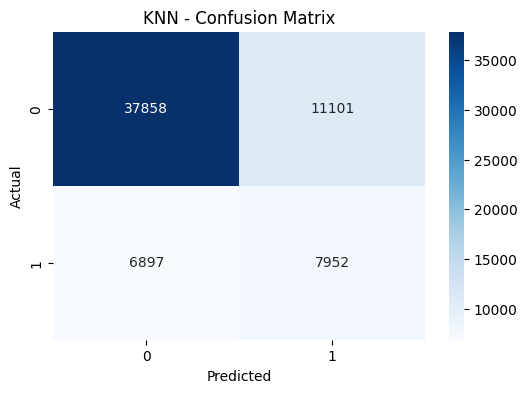

In [ ]:
knn_best = {'n': 0, 'acc': 0, 'knn': 0}

for n in range(12, 30):
  knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski', n_jobs=-1)
  knn.fit(X_train_pca, y_train_smote)
  result = knn.predict(X_val_pca)

  knn_acc = accuracy_score(y_val_smote, result)

  print("Trying for num of neighbours = ", n)
  print("Acurracy:", knn_acc)
  print("ROC AUC: ", roc_auc_score(y_val_smote, result))

  if knn_acc > knn_best['acc']:
    knn_best['n'] = n
    knn_best['acc'] = knn_acc
    knn_best['knn'] = knn

  print("\n")

print("Best n:", knn_best['n'])
print("Best accuracy for validation:", knn_best['acc'])

y_pred = knn_best['knn'].predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report for test:\n", classification_report(y_test, y_pred))
print("ROC AUC for test: ", roc_auc_score(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## **Perceptron**

Trying for eta =  1
Acurracy: 0.5448367661482416
ROC AUC:  0.5448367661482416


Trying for eta =  0.1
Acurracy: 0.5448367661482416
ROC AUC:  0.5448367661482416


Trying for eta =  0.01
Acurracy: 0.5207895474288917
ROC AUC:  0.5207895474288917


Trying for eta =  0.001
Acurracy: 0.5207895474288917
ROC AUC:  0.5207895474288917


Trying for eta =  0.0001
Acurracy: 0.5207895474288917
ROC AUC:  0.5207895474288917


Best eta for validation: 1
Best accuracy for validation: 0.5448367661482416
Accuracy for test: 0.5907723169508525
Classification Report for test:
               precision    recall  f1-score   support

           0       0.79      0.63      0.70     48959
           1       0.27      0.45      0.34     14849

    accuracy                           0.59     63808
   macro avg       0.53      0.54      0.52     63808
weighted avg       0.67      0.59      0.62     63808

ROC AUC for test:  0.5421550009469084


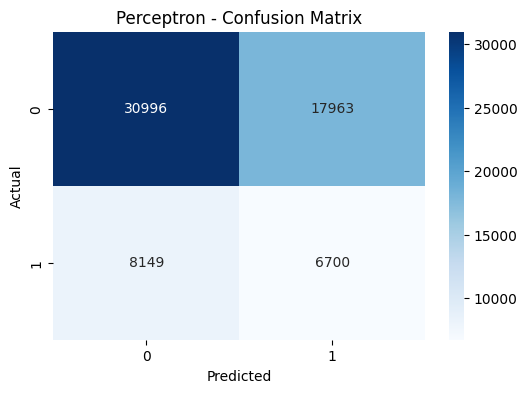

In [ ]:
ppn_best = {'eta': 0, 'acc': 0, 'ppn': 0}

for e in [1, 0.1, 0.01, 0.001, 0.0001]:
  ppn = Perceptron(max_iter=10000, eta0=e, random_state=10)
  ppn.fit(X_train_pca, y_train_smote)
  result = ppn.predict(X_val_pca)

  ppn_acc = accuracy_score(y_val_smote, result)

  print("Trying for eta = ", e)
  print("Acurracy:", ppn_acc)
  print("ROC AUC: ", roc_auc_score(y_val_smote, result))

  if ppn_acc > ppn_best['acc']:
    ppn_best['eta'] = e
    ppn_best['acc'] = ppn_acc
    ppn_best['ppn'] = ppn

  print("\n")

print("Best eta for validation:", ppn_best['eta'])
print("Best accuracy for validation:", ppn_best['acc'])

y_pred = ppn_best['ppn'].predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report for test:\n", classification_report(y_test, y_pred))
print("ROC AUC for test: ", roc_auc_score(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Perceptron - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **Linear SVC**

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



=== Best Model by Accuracy ===
C: 10
Penalty: l2
Accuracy: 0.6683480453972257
AUC-ROC: 0.6910298445215479


Accuracy for test: 0.7413803911735206
Classification Report for test:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83     48959
           1       0.45      0.54      0.49     14849

    accuracy                           0.74     63808
   macro avg       0.65      0.67      0.66     63808
weighted avg       0.76      0.74      0.75     63808



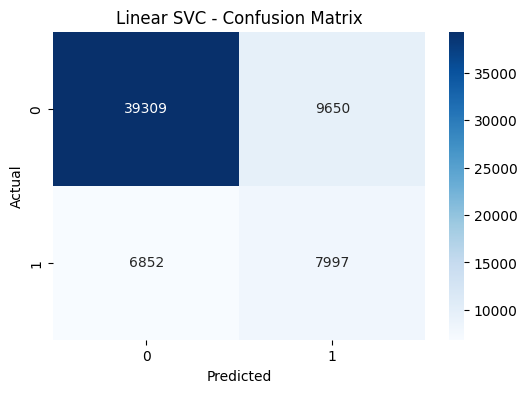


SHAP Values (Best Accuracy Model):
5    0.619086
8    0.197547
7    0.149413
9    0.117040
6    0.026177
2    0.009983
1    0.009272
3    0.005279
0    0.003876
4    0.001239
dtype: float64


In [ ]:
# Hyperparameter grids
C_vals = [0.1, 1, 5, 10, 25]
penalties = ['l1', 'l2']

best_accuracy = 0
best_auc = 0
best_model_acc = None
best_metrics_acc = {}

for C in C_vals:
    for penalty in penalties:
        if penalty == 'l1':
            loss = 'squared_hinge'
            dual = False
        else:
            loss = 'hinge'
            dual = True

        model = LinearSVC(
            C=C,
            penalty=penalty,
            loss=loss,
            dual=dual,
            class_weight=None,
            random_state=42,
            max_iter=10000
        )

        model.fit(X_train_pca, y_train_smote)
        y_pred = model.predict(X_val_pca)

        # Calculate metrics
        accuracy = accuracy_score(y_val_smote, y_pred)
        cm = confusion_matrix(y_val_smote, y_pred)

        auc_roc = None
        if len(y_val_smote.unique()) == 2:
            decision_scores = model.decision_function(X_val_pca)
            auc_roc = roc_auc_score(y_val_smote, decision_scores)

        # Track best accuracy model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_metrics_acc = {
                'C': C,
                'penalty': penalty,
                'accuracy': accuracy,
                'confusion_matrix': cm,
                'auc_roc': auc_roc,
                'model': model
            }

# Print best model by Accuracy
print("\n=== Best Model by Accuracy ===")
print(f"C: {best_metrics_acc['C']}")
print(f"Penalty: {best_metrics_acc['penalty']}")
print(f"Accuracy: {best_metrics_acc['accuracy']}")
if best_metrics_acc['auc_roc'] is not None:
    print(f"AUC-ROC: {best_metrics_acc['auc_roc']}")

print("\n")

y_pred = best_metrics_acc['model'].predict(X_test_pca)
print("Accuracy for test:", accuracy_score(y_test, y_pred))
print("Classification Report for test:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Linear SVC - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SHAP values for best accuracy model
explainer = shap.LinearExplainer(best_metrics_acc['model'], X_train_pca)
shap_values = explainer.shap_values(X_test_pca)
mean_abs_shap = pd.Series(np.abs(shap_values).mean(axis=0)).sort_values(ascending=False)
print("\nSHAP Values (Best Accuracy Model):")
print(mean_abs_shap)

## **SVC**

In [ ]:
# # Hyperparameter grids
# kernels = ['rbf', 'sigmoid', 'poly']
# C_vals = [0.1, 1, 5]
# gammas = ['scale', 'auto', 0.1]

# ## Using a downsized dataset

# svc_df = df2.sample(n=18750, random_state=42)

# X_svc = svc_df.drop('Diagnosis', axis=1)
# y_svc = svc_df['Diagnosis']

# X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_svc, test_size=0.2, random_state=1, stratify=y_svc)
# X_train_svc, X_val_svc, y_train_svc, y_val_svc = train_test_split(X_train_svc, y_train_svc, test_size=0.2, random_state=42)

# cols_to_scale = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

# sc_svc = StandardScaler()

# X_train_svc[cols_to_scale] = sc_svc.fit_transform(X_train_svc[cols_to_scale])
# X_test_svc[cols_to_scale] = sc_svc.transform(X_test_svc[cols_to_scale])
# X_val_svc[cols_to_scale] = sc_svc.transform(X_val_svc[cols_to_scale])
# ##

# best_models = {
#     'sigmoid': {'model': None, 'accuracy': 0, 'C': None, 'gamma': None},
#     'rbf': {'model': None, 'accuracy': 0, 'C': None, 'gamma': None},
#     'poly': {'model': None, 'accuracy': 0, 'C': None, 'gamma': None}
# }

# for kernel in kernels:
#     for C in C_vals:
#         for gamma in gammas:
#             # Skip invalid combinations
#             if kernel == 'linear' and gamma != 'scale':
#                 continue

#             model = SVC(
#                 kernel=kernel,
#                 C=C,
#                 gamma=gamma,
#                 probability=True,  # Required for AUC-ROC
#                 random_state=42
#             )

#             model.fit(X_train_svc, y_train_svc)
#             y_pred = model.predict(X_val_svc)
#             accuracy = accuracy_score(y_val_svc, y_pred)

#             # Update best model if current is better
#             if accuracy > best_models[kernel]['accuracy']:
#                 best_models[kernel]['model'] = model
#                 best_models[kernel]['accuracy'] = accuracy
#                 best_models[kernel]['C'] = C
#                 best_models[kernel]['gamma'] = gamma

# # Print results for each kernel
# for kernel in kernels:
#     best = best_models[kernel]
#     model = best['model']

#     # Get predictions and probabilities
#     y_pred = model.predict(X_test_svc)
#     y_proba = model.predict_proba(X_test_svc)[:, 1]  # Probability of positive class

#     # Calculate metrics
#     cm = confusion_matrix(y_test_svc, y_pred)
#     auc_roc = roc_auc_score(y_test_svc, y_proba)

#     print(f"\n=== Best {kernel} kernel ===")
#     print(f"C: {best['C']}, gamma: {best['gamma']}")
#     print(f"Accuracy: {best['accuracy']:.6f}")
#     print(f"AUC-ROC: {auc_roc:.6f}")
#     print("Confusion Matrix:")
#     print(cm)
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title("Kernel SVC - Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

## **Random Forest**

In [ ]:
# Your training and testing data
# X_train, X_test, y_train, y_test should already be defined

# Hyperparameter lists
n_estimators_list = [100, 200]
max_depth_list = [5, 10, 20]
min_samples_split_list = [2, 5, 10]

# Track best model
best_accuracy = 0
best_params = {}
best_model = None

# Train all combinations
for n_est in n_estimators_list:
    for depth in max_depth_list:
        for min_split in min_samples_split_list:
            model = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=depth,
                min_samples_split=min_split,
                class_weight=None,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train_pca, y_train_smote)

            y_pred = model.predict(X_test_pca)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'n_estimators': n_est,
                    'max_depth': depth,
                    'min_samples_split': min_split
                }
                best_model = model

# Results
print("=== BEST RANDOM FOREST MODEL ===")
print(", ".join([f"{key}: {value}" for key, value in best_params.items()]))
print(f"Accuracy: {best_accuracy:.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, best_model.predict_proba(X_test_pca)[:,1]):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_model.predict(X_test_pca)))
print("Classification Report for test:\n", classification_report(y_test, y_pred))

## Compute SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_pca)

# If shap_values is a list, it's per class — usually for binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_to_use = shap_values[1]  # Class 1 shap values
else:
    shap_values_to_use = shap_values

# Make sure shap_values_to_use is a numpy array
shap_values_to_use = np.array(shap_values_to_use)

# Now it should have shape (num_samples, num_features)
if shap_values_to_use.ndim == 3:
    # Collapse first dimension if needed
    shap_values_to_use = shap_values_to_use[:, :, 1]  # class 1

shap_df = pd.DataFrame(shap_values_to_use)
mean_shap = shap_df.abs().mean().sort_values(ascending=False)
print("\nSHAP Values (Best RF Model):")
print(mean_shap)

=== BEST RANDOM FOREST MODEL ===
n_estimators: 200, max_depth: 10, min_samples_split: 2
Accuracy: 0.8289
AUC-ROC: 0.6970

Confusion Matrix:
[[46165  2794]
 [ 8126  6723]]
Classification Report for test:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     48959
           1       0.69      0.45      0.55     14849

    accuracy                           0.83     63808
   macro avg       0.77      0.70      0.72     63808
weighted avg       0.81      0.83      0.81     63808


SHAP Values (Best RF Model):
5    0.082196
9    0.066685
8    0.019091
7    0.018802
6    0.006079
4    0.003344
3    0.002720
1    0.002227
0    0.001709
2    0.001703
dtype: float64


## **Logistic Regresssion**

In [ ]:
# Set up the parameter grid
param_grid_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cg'],
    'penalty': ['l2'],
    'max_iter': [500, 1000, 2000]


}


# Instantiate GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced'),
                       param_grid=param_grid_lr,
                       cv=5,
                       scoring='f1_macro',
                       n_jobs=-1)

# Fit the model
grid_lr.fit(X_train_pca, y_train_smote)

# Evaluate
print("Best Parameters:", grid_lr.best_params_)

best_lr = grid_lr.best_estimator_
y_pred = best_lr.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.0001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6841618605817452
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.78     48959
           1       0.38      0.59      0.47     14849

    accuracy                           0.68     63808
   macro avg       0.62      0.65      0.62     63808
weighted avg       0.74      0.68      0.70     63808



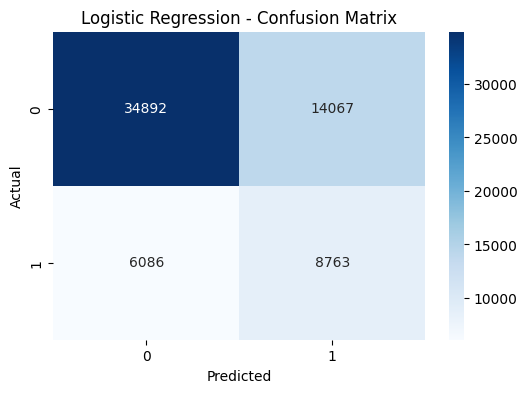

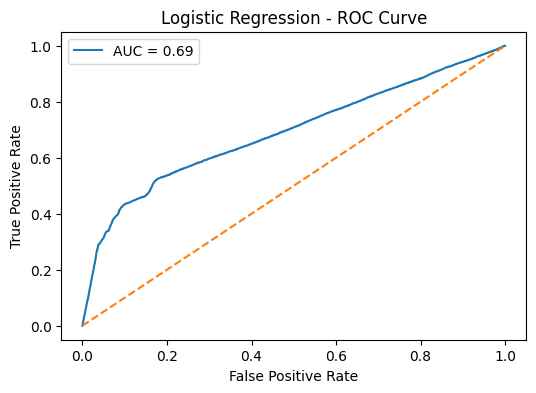

In [ ]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
y_probs = best_lr.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## **Decision Tree**

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.6781908224674023
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78     48959
           1       0.36      0.47      0.41     14849

    accuracy                           0.68     63808
   macro avg       0.59      0.61      0.59     63808
weighted avg       0.71      0.68      0.69     63808



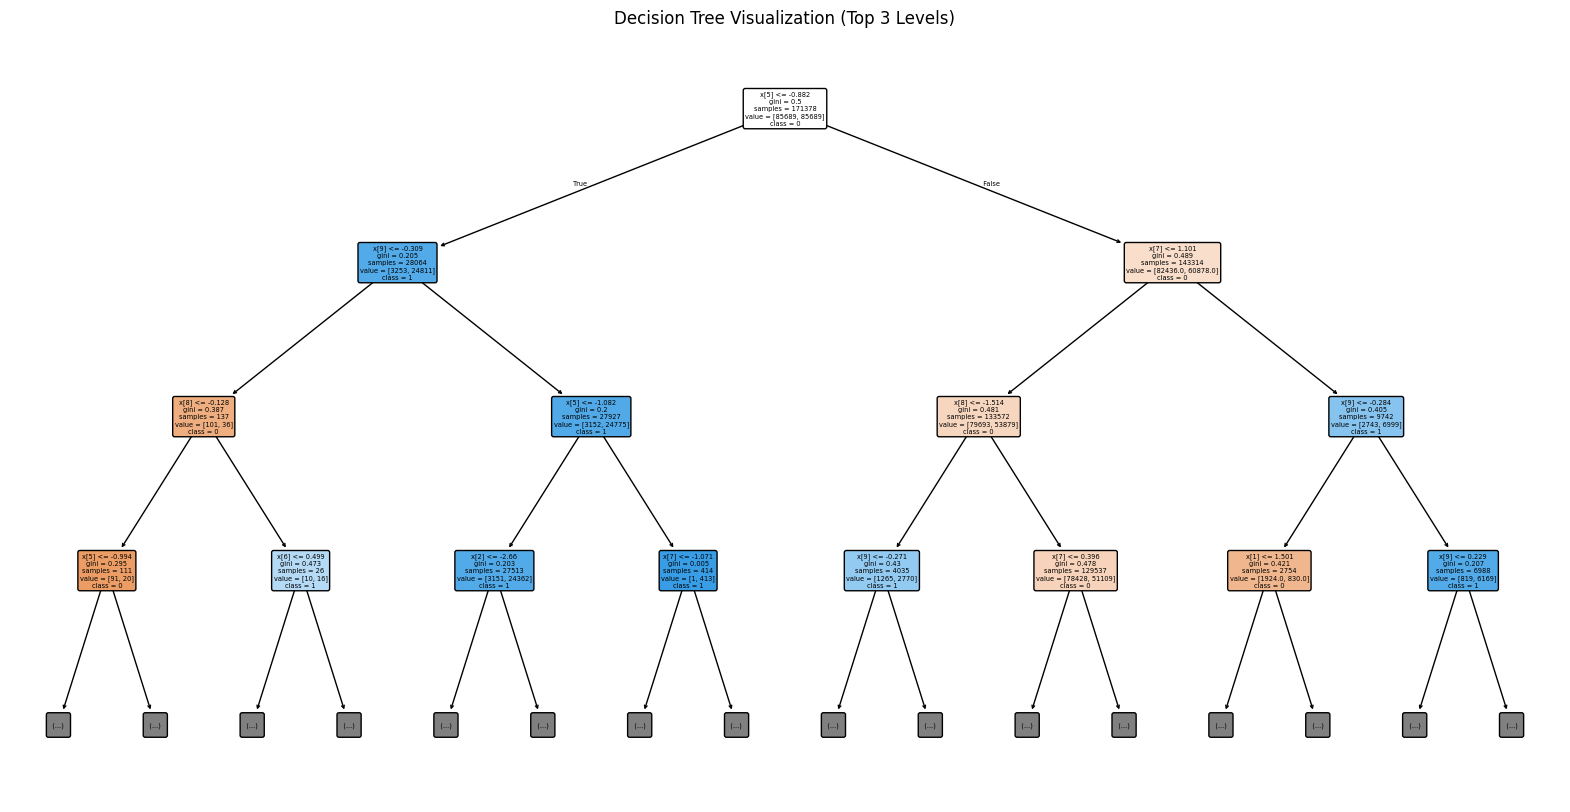

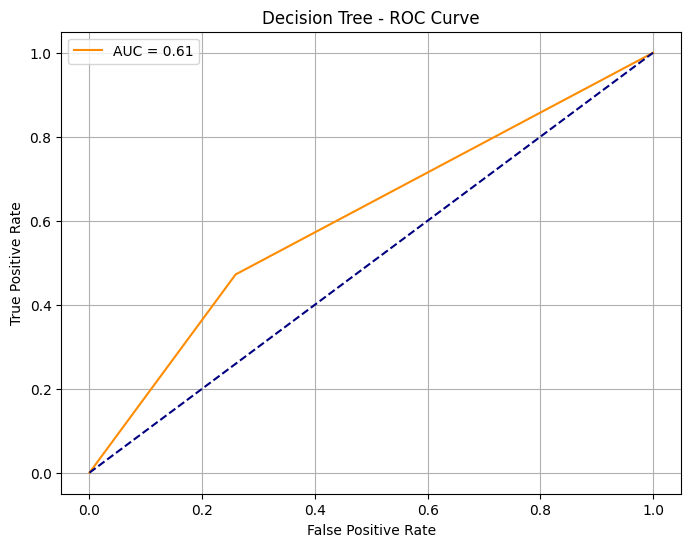

In [ ]:
from sklearn.tree import DecisionTreeClassifier  # Make sure to import
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree # Import plot_tree for visualization
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for array operations
import seaborn as sns
from sklearn.metrics import confusion_matrix

param_grid_dt = {
    'max_depth': [15, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                       param_grid=param_grid_dt,
                       cv=5, scoring='f1_macro')

grid_dt.fit(X_train_pca, y_train_smote)

print("Best Parameters:", grid_dt.best_params_)

# Predict using best estimator
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# --- Visualization of the Decision Tree ---
plt.figure(figsize=(20, 10))  # Wider figure for bigger trees
plot_tree(best_dt,
          class_names=[str(cls) for cls in np.unique(y_train_smote)],
          filled=True,
          rounded=True,
          max_depth=3)  #  show top 3 levels
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

y_pred_proba_dt = best_dt.predict_proba(X_test_pca)[:, 1]  # Probabilities for class 1

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'AUC = {roc_auc_dt:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Adaline**

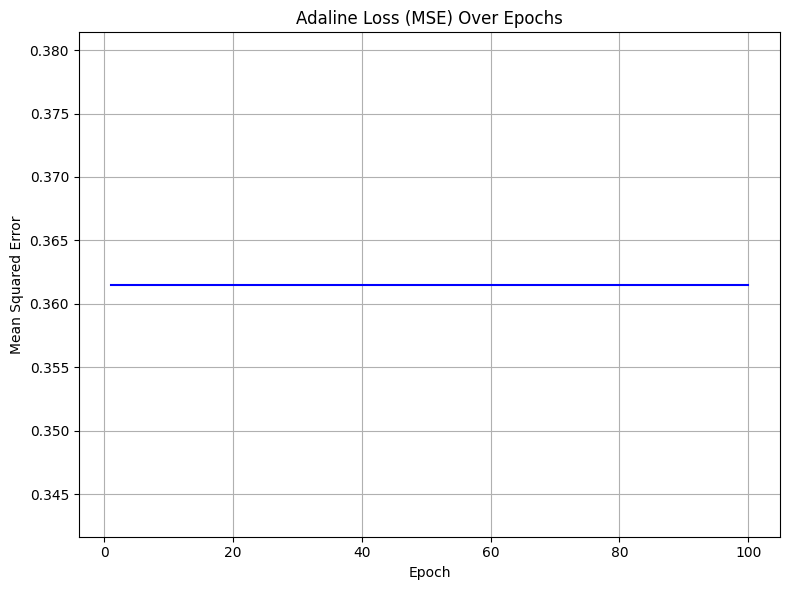

Accuracy: 0.6744765546639919
Confusion Matrix:
 [[34269 14690]
 [ 6081  8768]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77     48959
           1       0.37      0.59      0.46     14849

    accuracy                           0.67     63808
   macro avg       0.61      0.65      0.61     63808
weighted avg       0.74      0.67      0.70     63808



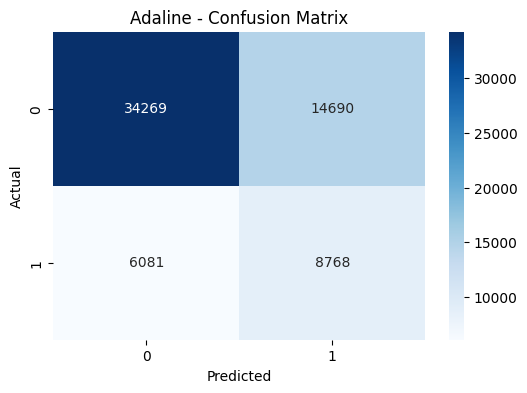

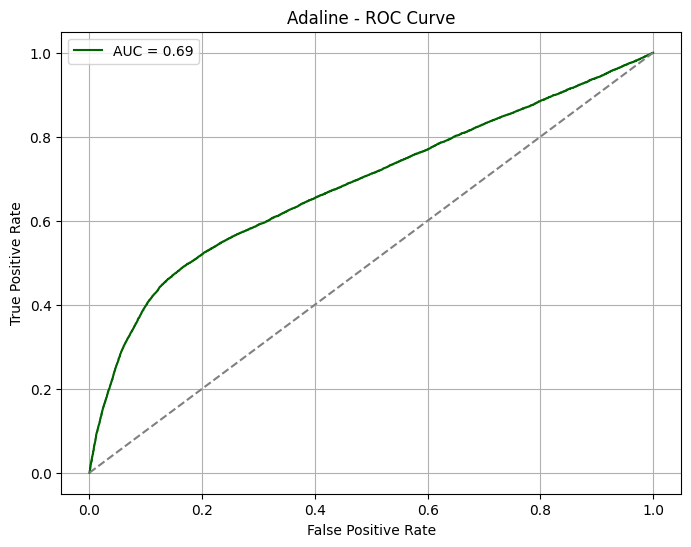

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

# Use all features for better model performance
X_train_vis = X_train_pca
X_test_vis = X_test_pca

# Initialize the classifier
adaline = SGDClassifier(loss='squared_error', learning_rate='constant', eta0=0.01,
                        max_iter=1, random_state=42, tol=None, warm_start=True)

# Partial fit setup
n_epochs = 100
loss_values = []

classes = np.unique(y_train_smote)
adaline.partial_fit(X_train_vis, y_train_smote, classes=classes)

# Track MSE loss over epochs using partial_fit
for epoch in range(n_epochs):
    y_train_pred = adaline.predict(X_train_vis)
    loss = mean_squared_error(y_train_smote, y_train_pred)
    loss_values.append(loss)
    adaline.partial_fit(X_train_vis, y_train_smote)

# Plot loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_epochs + 1), loss_values, color='blue')
plt.title("Adaline Loss (MSE) Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Final evaluation
y_pred_adaline = adaline.predict(X_test_vis)
print("Accuracy:", accuracy_score(y_test, y_pred_adaline))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adaline))
print("Classification Report:\n", classification_report(y_test, y_pred_adaline))

# --- Confusion Matrix Plot ---
conf_matrix_adaline = confusion_matrix(y_test, y_pred_adaline)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_adaline, annot=True, fmt='d', cmap='Blues')
plt.title("Adaline - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC AUC Curve ---
# Note: For ROC, we need decision function or probabilities
y_scores_adaline = adaline.decision_function(X_test_vis)

fpr_adaline, tpr_adaline, thresholds_adaline = roc_curve(y_test, y_scores_adaline)
roc_auc_adaline = roc_auc_score(y_test, y_scores_adaline)

plt.figure(figsize=(8, 6))
plt.plot(fpr_adaline, tpr_adaline, label=f'AUC = {roc_auc_adaline:.2f}', color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaline - ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Linear Regression**

In [ ]:
model = LinearRegression()
model.fit(X_train_pca, y_train_smote)


def predict_from_model(data, trained_model):
    return trained_model.predict(data)

print(predict_from_model(X_test_pca, model))
y_pred = predict_from_model(X_test_pca, model)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² score:", r2_score(y_test, y_pred))

[0.42460365 0.64412376 0.76288244 ... 0.75009552 0.79523803 0.52391614]
Mean Squared Error: 0.2113067648280475
R² score: -0.1834064161163007


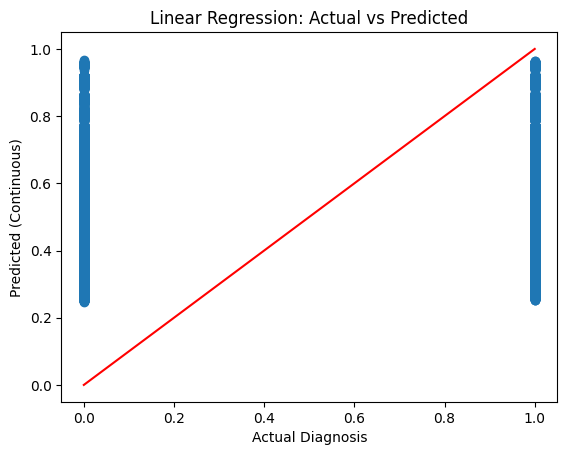

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Diagnosis")
plt.ylabel("Predicted (Continuous)")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # perfect fit line
plt.show()

## **Naive Bayes**

In [ ]:
# Train the model
nb_model = GaussianNB()
nb_model.fit(X_train_pca, y_train_smote)

# Predict class labels and class probabilities
y_pred = nb_model.predict(X_test_pca)
y_score = nb_model.predict_proba(X_test_pca)[:, 1]  # use probability for class 1

# Compute AUC (binary)
auc = roc_auc_score(y_test, y_score)

# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("AUC:", auc)

# We could use MultinomialNB, or BernoulliNB if features are mostly 0/1 (like post-one-hot-encoding)

Accuracy: 0.7530873871614845
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     48959
           1       0.47      0.49      0.48     14849

    accuracy                           0.75     63808
   macro avg       0.66      0.66      0.66     63808
weighted avg       0.76      0.75      0.75     63808

[[40767  8192]
 [ 7563  7286]]
AUC: 0.6893937929520346


## **Neural Networks using Keras**

2
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8569/8569 - 41s - 5ms/step - accuracy: 0.7332 - loss: 0.5767 - val_accuracy: 0.4805 - val_loss: 0.7829
Epoch 2/50
8569/8569 - 36s - 4ms/step - accuracy: 0.7585 - loss: 0.5523 - val_accuracy: 0.4824 - val_loss: 0.7415
Epoch 3/50
8569/8569 - 24s - 3ms/step - accuracy: 0.7630 - loss: 0.5469 - val_accuracy: 0.4901 - val_loss: 0.7537
Epoch 4/50
8569/8569 - 23s - 3ms/step - accuracy: 0.7641 - loss: 0.5450 - val_accuracy: 0.4918 - val_loss: 0.7833
Epoch 5/50
8569/8569 - 21s - 2ms/step - accuracy: 0.7648 - loss: 0.5434 - val_accuracy: 0.4936 - val_loss: 0.7497
Epoch 6/50
8569/8569 - 42s - 5ms/step - accuracy: 0.7646 - loss: 0.5425 - val_accuracy: 0.4947 - val_loss: 0.7338
Epoch 7/50
8569/8569 - 42s - 5ms/step - accuracy: 0.7650 - loss: 0.5423 - val_accuracy: 0.4933 - val_loss: 0.7887
Epoch 8/50
8569/8569 - 21s - 2ms/step - accuracy: 0.7651 - loss: 0.5419 - val_accuracy: 0.4943 - val_loss: 0.7745
Epoch 9/50
8569/8569 - 44s - 5ms/step - accuracy: 0.7652 - loss: 0.5414 - val_accuracy: 0.4939 - va

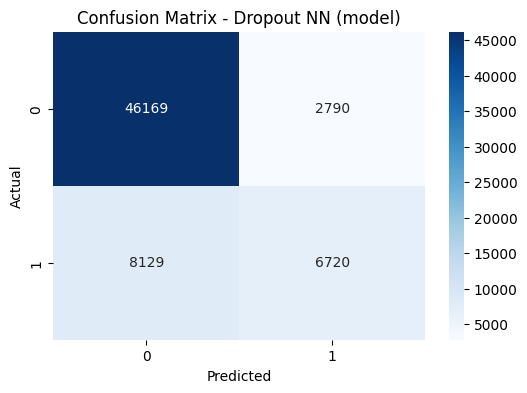

Accuracy (model): 0.8288772567703109
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     48959
           1       0.71      0.45      0.55     14849

    accuracy                           0.83     63808
   macro avg       0.78      0.70      0.72     63808
weighted avg       0.82      0.83      0.81     63808

AUC (model): 0.6954121333883763


In [ ]:

# One-hot encode your multi-class target
num_classes = len(np.unique(y_train_smote))
print(num_classes)
y_train_cat = to_categorical(y_train_smote, num_classes)
#y_val_cat = to_categorical(y_val_smote, num_classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_pca, y_train_cat,
    epochs=50,
    batch_size=16,  # Still using smaller batch for stability
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop]
)

# Evaluate
y_pred_prob = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_prob, axis=1)
y_score = y_pred_prob[:, 1]
auc_score = roc_auc_score(y_test, y_score)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Dropout NN (model)")
plt.show()

# Print final metrics
print("Accuracy (model):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC (model):", auc_score)





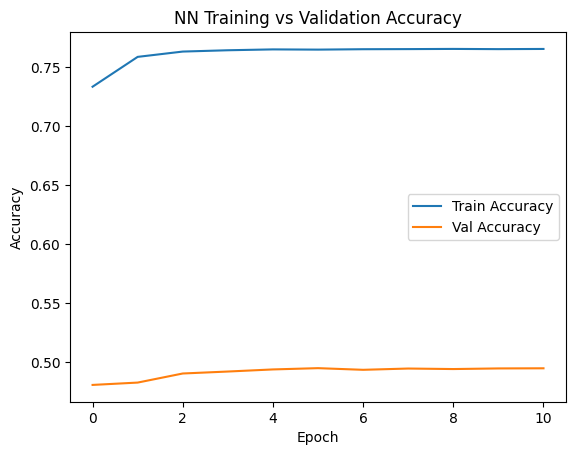

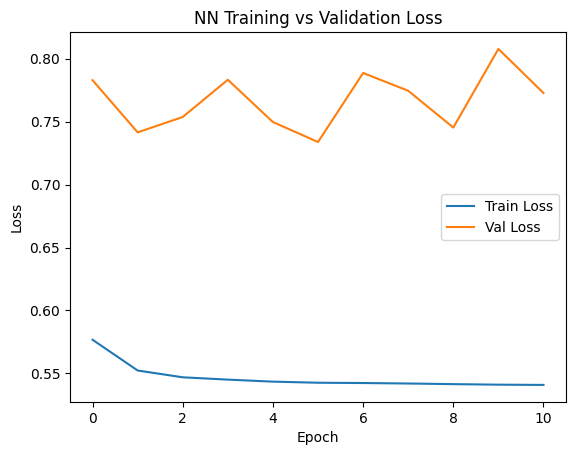

In [ ]:
#Accuracy and Loss Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('NN Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Training vs Validation Loss')
plt.legend()
plt.show()

#These graphs are labeled "Training vs Validation" because they come from Keras' internal training
#process. We used validation_split=0.2, which means these metrics are based on the training data and
#a held-out validation set — not the test set. The test set is only used at the end for final evaluation.

## **SHAP (for NN)**


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


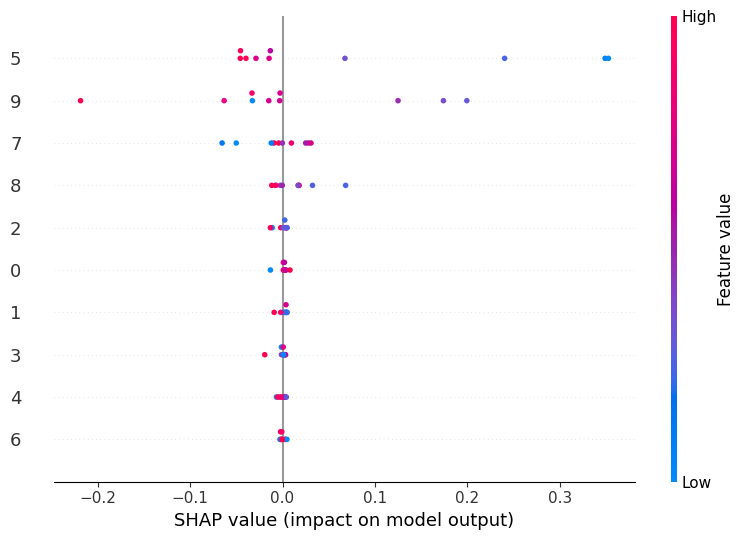

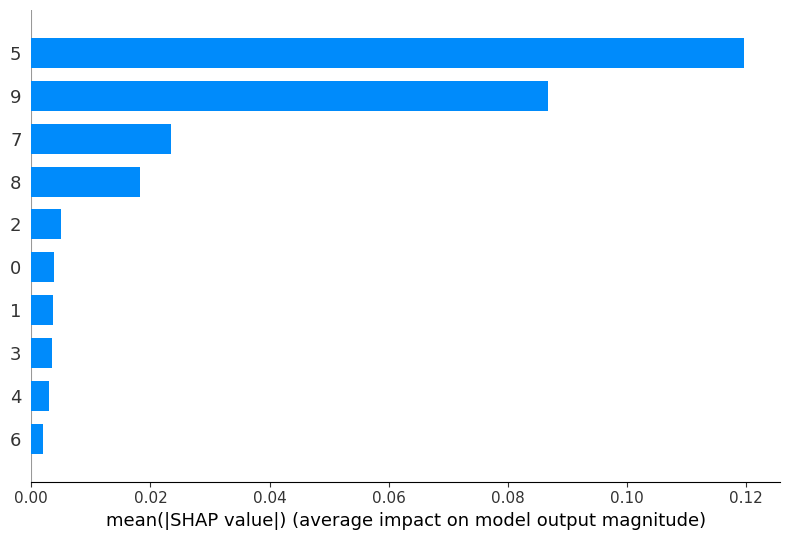

In [ ]:
X_test_pca_input = pd.DataFrame(X_test_pca)

feature_names = []
for col in X_test_pca_input.columns:
    if col in ['Thyroid_Cancer_Risk_High', 'Thyroid_Cancer_Risk_Low', 'Thyroid_Cancer_Risk_Medium']:
        feature_names.append('(Label) ' + col)  # Mark them obviously
    else:
        feature_names.append(col)

background = shap.utils.sample(X_test_pca_input, 50, random_state=42)

def predict_proba_class1(x):
    preds = model.predict(x)
    return preds[:, 1]

explainer = shap.KernelExplainer(predict_proba_class1, background)

shap_values = explainer.shap_values(X_test_pca_input[:10])

shap.summary_plot(shap_values, X_test_pca_input[:10], feature_names=feature_names)
shap.summary_plot(shap_values, X_test_pca_input[:10], feature_names=feature_names, plot_type="bar")
